# Binary Classification with a Bank Churn Dataset
## Playground Series - Season 4, Episode 1

In [43]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [2]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [3]:
train.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [6]:
test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [7]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [8]:
print(train.shape)
print(test.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [9]:
# let's start looking at the training data
train.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [10]:
train.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

### 1.6) Check for Outliers

- **Customer ID**:
  - Treatment: Exclude from modeling or use it as an index, but do not include it as a feature in your predictive model.
  - Why: Customer ID is usually a unique identifier and does not contribute to the model's predictive power. Including it may lead to overfitting, as the
  model might mistakenly learn patterns specific to individual customers that do not generalize well.

- **Surname**:
  - Treatment: Exclude from modeling.
  - Why: Surnames are categorical data, but including them in a model might not provide meaningful information. If you attempt to one-hot encode surnames, it could lead to an extremely high-dimensional dataset, making the model computationally expensive and potentially overfit to the training data.

In [11]:
def plot_numerical_features(data):
    """
    Plot the distribution, boxplot, and Gaussianity of numerical features in the given dataset.

    Args:
        data (pandas.DataFrame): The dataset containing numerical features.

    Returns:
        None
    """
    data = data.copy()
    
    # drop target variable, customer id, and surname
    data.drop(columns=['CustomerId','Surname','Exited'], inplace=True)
    
    X_num = data.select_dtypes(exclude='object')
    
    for numerical_feature in X_num.columns:
        
        # Creating three subplots per numerical_feature
        fig, ax =plt.subplots(1,3,figsize=(15,3))
        
        # Histogram to get an overview of the distribution of each numerical_feature
        ax[0].set_title(f"Distribution of: {numerical_feature}")
        sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])
        
        # Boxplot to detect outliers
        ax[1].set_title(f"Boxplot of: {numerical_feature}")
        sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])
        
        # Analyzing whether a feature is normally distributed or not
        ax[2].set_title(f"Gaussianity of: {numerical_feature}")
        qqplot(X_num[numerical_feature],line='s',ax=ax[2])


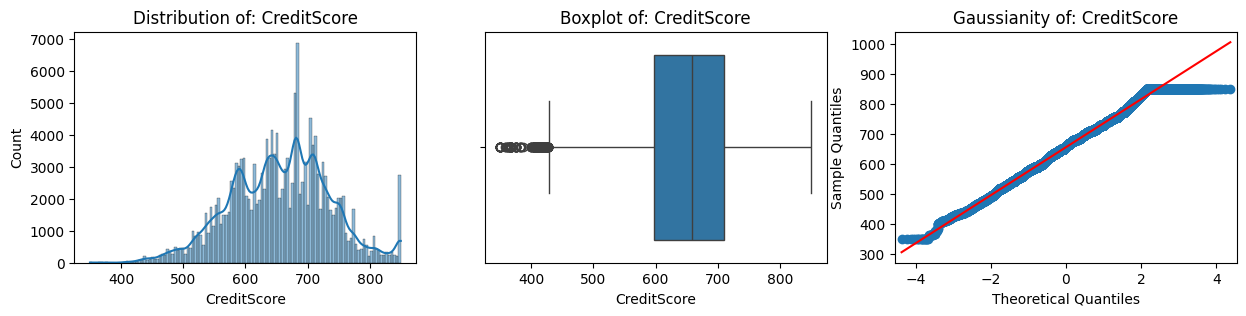

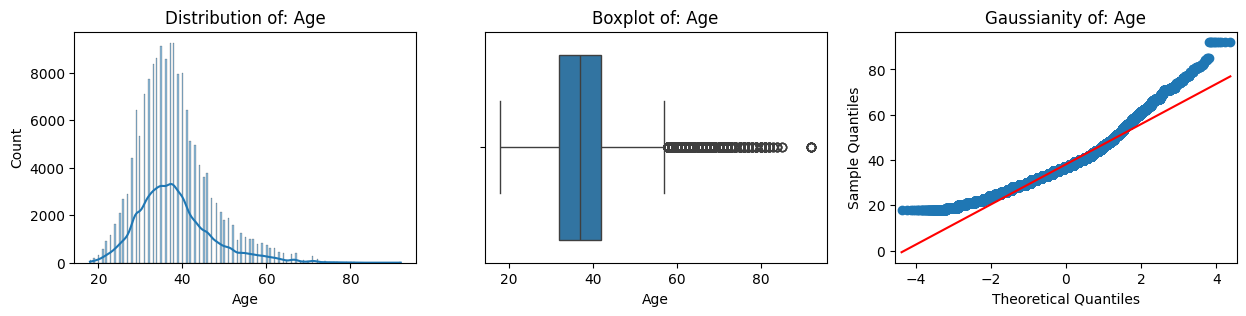

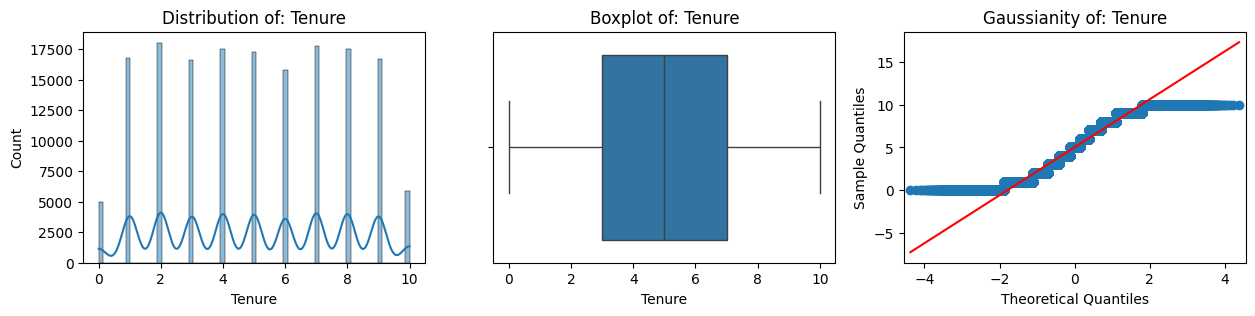

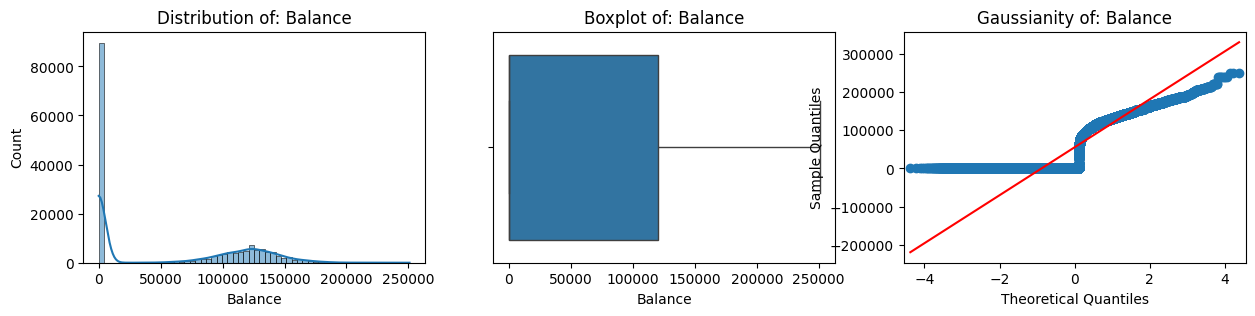

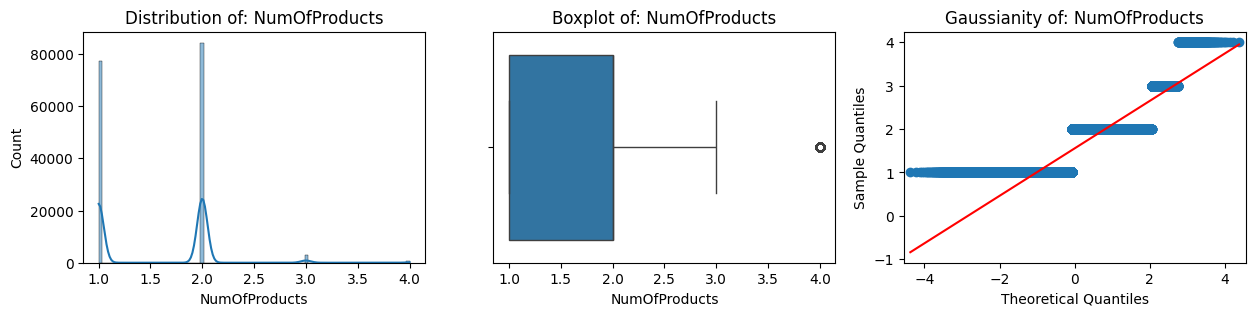

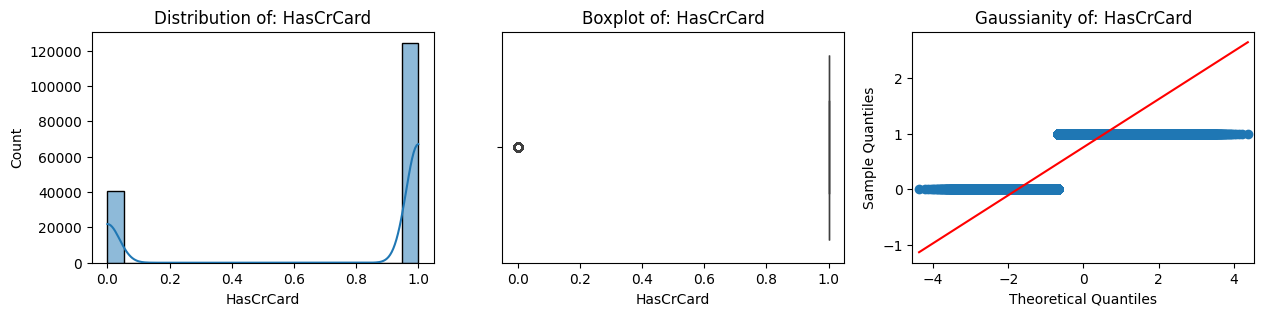

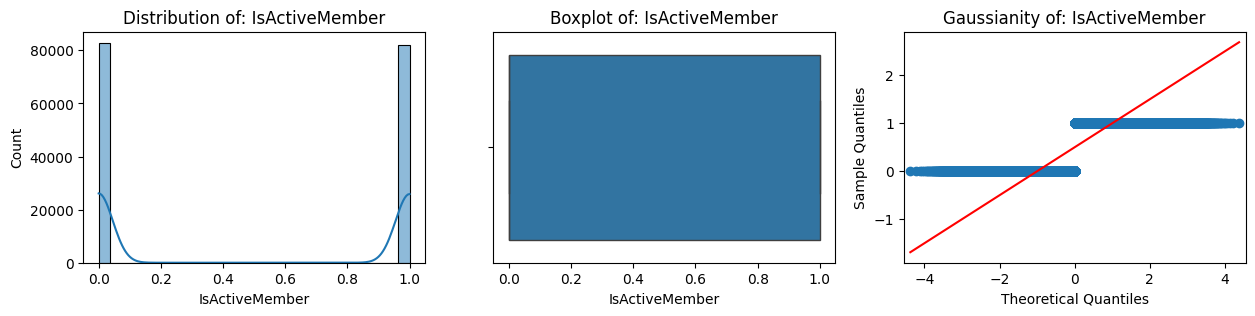

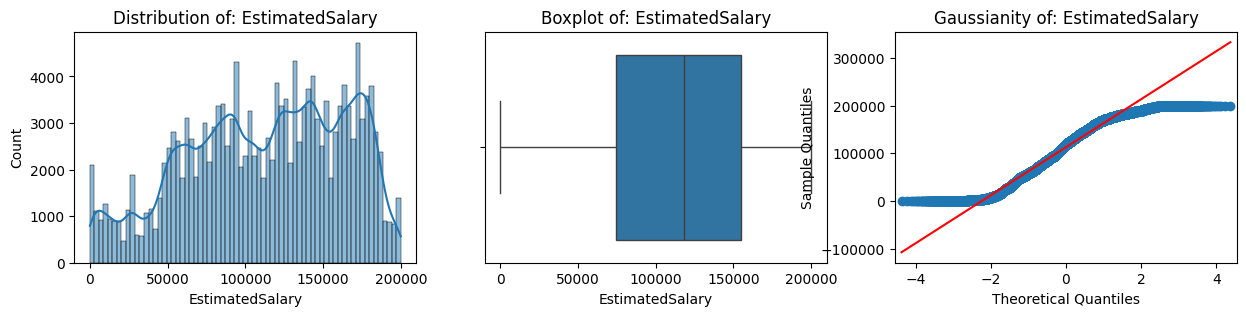

In [12]:
plot_numerical_features(data=train)

In [13]:
train.select_dtypes(exclude='object').columns

Index(['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## 2) Improve Model

In [44]:
num_columns = ['CreditScore', 'Age' , 'Balance', 'EstimatedSalary']
cat_columns = ['Geography','Gender','HasCrCard' ,'IsActiveMember','NumOfProducts','Tenure']


preproc_numerical_baseline = make_pipeline(
    RobustScaler()
)

preproc_categorical_baseline = make_pipeline(
    OneHotEncoder(sparse_output = False, handle_unknown='ignore')
)
 
preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, num_columns),
    (preproc_categorical_baseline, cat_columns),
    remainder='drop'
)

pipe_baseline = make_pipeline(preproc_baseline, RandomForestClassifier(random_state=42))

pipe_ensemble = make_pipeline(preproc_baseline, AdaBoostClassifier(base_estimator=pipe_baseline, random_state=42))

#### Predict Baseline

In [45]:
X = train.drop(columns=['Exited','Surname','CustomerId'])
y = train['Exited']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


# Example: Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Update RandomForestClassifier in the pipeline with class_weight
pipe_ensemble.steps[-1] = ('randomforestclassifier', RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)), random_state=42))

pipe_ensemble.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance',
                                                   'EstimatedSalary']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts',
                                                   'Tenure'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.634196368527236,
                                                      1: 2.3629416186419445},
                                        random_state=42))])

Score: 0.869


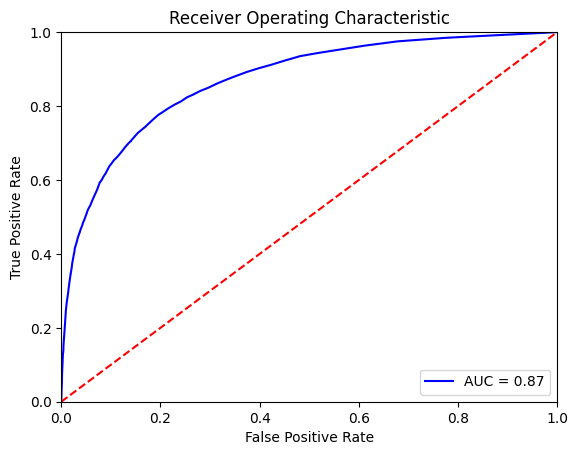

In [47]:
y_scores = pipe_ensemble.predict_proba(X_val)[:,1]

fpr, tpr, threshold = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

## 3) Submission

In [50]:
test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
165034,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [51]:
# first submission
test = test.copy()

# predict
y_pred = pipe_ensemble.predict(test)

# add to submission dataframe
submission['Exited'] = y_pred

# save to csv
submission.to_csv('data/submission_2.csv', index=False)

# first value for my baseline was: 0.73470